In [2]:
import numpy as np
import scipy.sparse as sp
from sklearn.utils.extmath import randomized_svd

### Generowanie macierzy rzadkich

In [3]:
def sparse_matrix(rows, cols, density):
    return sp.rand(rows, cols, density=density)

### Klasa węzła

In [4]:
class CompressNode:
    def __init__(self, rank=0, children=None, singular_values=None, U=None, V=None, size=None):
        self.rank = rank
        self.children = children
        self.s = singular_values
        self.U = U
        self.V = V
        self.size = size
        self.val = None
        
    def append_child(self, child):
        self.children.append(child)
    
    def __str__(self):
        return f'Node: rank = {self.rank}; children: {self.children}; s: {self.s}; U = {self.U}; V = {self.V}, size = {self.size}'

In [5]:
def compress_matrix(m, U, s, V, r, epsilon):
    if (m == 0).all():
        v = CompressNode(size=m.shape)
        return v
    else:  
        s_no = len(s[s > epsilon])
        
        rank = max(min(r, s_no), 1) # Tego też nie jestem pewny
        
        D = np.diag(s[0:rank])
        v = CompressNode(rank=rank, singular_values=s[0:rank], U=U[:, 0:rank], V=D@V[0:rank, :], size=m.shape)
        return v
        

In [6]:
def create_tree(m, r, epsilon):
    rank = min(r, m.shape[0])
    
    svd = TruncatedSVD(n_components=rank)
    U = svd.fit_transform(m)
    s = svd.singular_values_
    V = svd.components_
    
    if s[rank - 1] < epsilon: # nie wiem czy nie powinno być s[r - 1] < epsilon - tak jest na wykładzie
        v = compress_matrix(m, U, s, V, r, epsilon)
        return v
    else:
        v = CompressNode(children=[], singular_values=[],U=[], V=[])
        Y, X = m.shape
        v.append_child(create_tree(m[0: Y // 2, 0 : X // 2], r, epsilon))
        v.append_child(create_tree(m[0: Y // 2, X // 2: X], r, epsilon))
        v.append_child(create_tree(m[Y // 2: Y, 0 : X // 2], r, epsilon))
        v.append_child(create_tree(m[Y // 2: Y, X // 2: X], r, epsilon))
        return v

### Kompresja

In [7]:
def compress_matrix(matrix, U, s, V, r):
    node = None
    if (matrix == 0).all():
        node = CompressNode(rank=0, size=matrix.shape)
    
    else:
        D = np.diag(s)
        node = CompressNode(rank=r, singular_values=s[:r], U=U[:, :r], V=D[:r, :r] @ V[:r, ], 
                            size=matrix.shape)
    
    return node

In [8]:
def create_tree(matrix, r, epsilon):
    U, s, V = randomized_svd(matrix, n_components=r)
    
    node = None
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, r)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node


### Dekompresja

In [9]:
def decompression(root):
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return np.zeros(root.size)
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            return root.val
        return root.U @ root.V # maybe @singular_values, but I think it has already done
    
    else:
        children_dec = [decompression(child) for child in root.children]
        
        
        return np.vstack((np.hstack((children_dec[0], children_dec[1])),
                        np.hstack((children_dec[2], children_dec[3]))))    

### Różnica

In [10]:
def diff(original, decompressed):
    return np.square(original - decompressed)

In [25]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Wizualizacja macierzy
def wisualize_matrix(sparse_matrix):
    plt.imshow(sparse_matrix.toarray(), cmap='Greys', interpolation='none')
    plt.title('Macierz Rzadka')
    plt.colorbar(label='Wartość')
    plt.show()

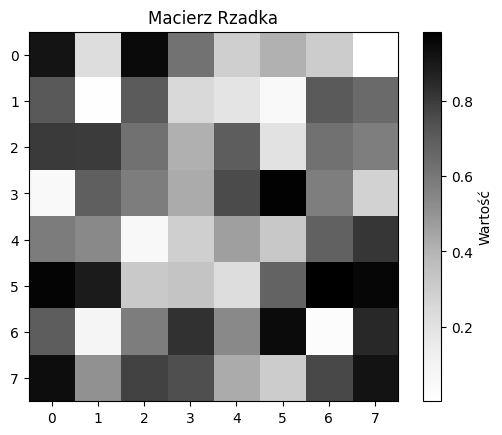

In [24]:
matrix = sparse_matrix(8, 8, 1)

wisualize_sparsed_matrix(matrix)